# we want to check whether the damage likelihood is correct. 

In [83]:
# we want to check whether the damage likelihood is correct. 
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [84]:
@jax.jit

def indicator(x):
    return(jnp.select([x>0,x<=0],[1,0]))

def logit(x):
    return(jnp.log(x/(1-x)))


def expit(x):
    return 1/(1+jnp.exp(-x))


def sigmoid(x, s):
    # x = jnp.array(x)
    # a = jnp.array(a)
    return 0.5 * (jnp.tanh(x * s / 2) + 1)

def dmgmodel_ind(y,alpha,l,c):
    return(y*indicator(c*y-l) + alpha*y*indicator(l-c*y))


def dmgmodel_py(y,alpha,l,c,s):
    #return(y*jax.scipy.stats.norm.cdf(c*y-l) + alpha*y*jax.scipy.stats.norm.cdf(l-c*y))
    return(y*sigmoid(c*y-l,s) + alpha*y*sigmoid(l-c*y,s))

    #return(y*g_smooth(c*y-l) + alpha*y*g_smooth(l-c*y))

def dmgmodel_root_py(y,alpha,l,c,s,ystar):
    return(dmgmodel_py(y,alpha,l,c,s) - ystar)



def dmginverse_py(ystar,alpha,l,c,s):
    ystar = jnp.array(ystar)
    bisec = jaxopt.Bisection(
        optimality_fun=dmgmodel_root_py,
        lower = 0,
        upper = 10000,
        check_bracket = False)
    return(bisec.run(alpha = alpha,l = l, c= c ,s = s,ystar = ystar).params)

def dmginvgrad_py(ystar,alpha,l,c,s):
    grad_func = jax.grad(dmginverse_py,0)
    return(jnp.abs(grad_func(ystar,alpha,l,c,s)))

def dmglik_py(ystar,alpha,l,c,s,mu,sigma):
    y =  dmginverse_py(ystar,alpha,l,c,s)
    return(jax.scipy.stats.norm.logpdf(y,loc = mu,scale = sigma)+ 
           jnp.log(dmginvgrad_py(ystar,alpha,l,c,s))
          )


def dmglik_vmap(y_group,alpha,l,c,s,mu,sigma):
    y_group = jnp.array(y_group)
    lik = jax.vmap(lambda y_group: dmglik_py(ystar = y_group,
                                             alpha = alpha,l = l, c= c,s =s,mu = mu, sigma=sigma))(y_group)
    return(jnp.sum(lik))



In [85]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
alpha = 0.25
c = 0.65
s = 10

N_marginal = 139





In [86]:
# data generation 
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[1], shape=(N, )) + mu
y = y[y>0]

y_obs = jax.vmap(lambda y: dmgmodel_py(y,alpha,l,c,s))(y)




In [87]:
s= s
l = l 

@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    c = theta[3]
    
    lik = dmglik_vmap(y_group = y_obs,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)

    return(-lik)

theta0 = jnp.array([mu,sigma,alpha,c])
negdmglik_jax(theta0)

Array(1120.0679, dtype=float32)

In [88]:


solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(theta0)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
theta0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


(Array([48.766502  , 17.297583  ,  0.24299887,  0.6501896 ], dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(1117.6467, dtype=float32), success=True, status=0, iter_num=81, hess_inv=None))

Array([48.  , 19.  ,  0.25,  0.65], dtype=float32)

Array([[24.383251  , 73.14975   ],
       [ 8.648791  , 25.946373  ],
       [ 0.12149943,  0.36449832],
       [ 0.3250948 ,  0.97528434]], dtype=float32)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


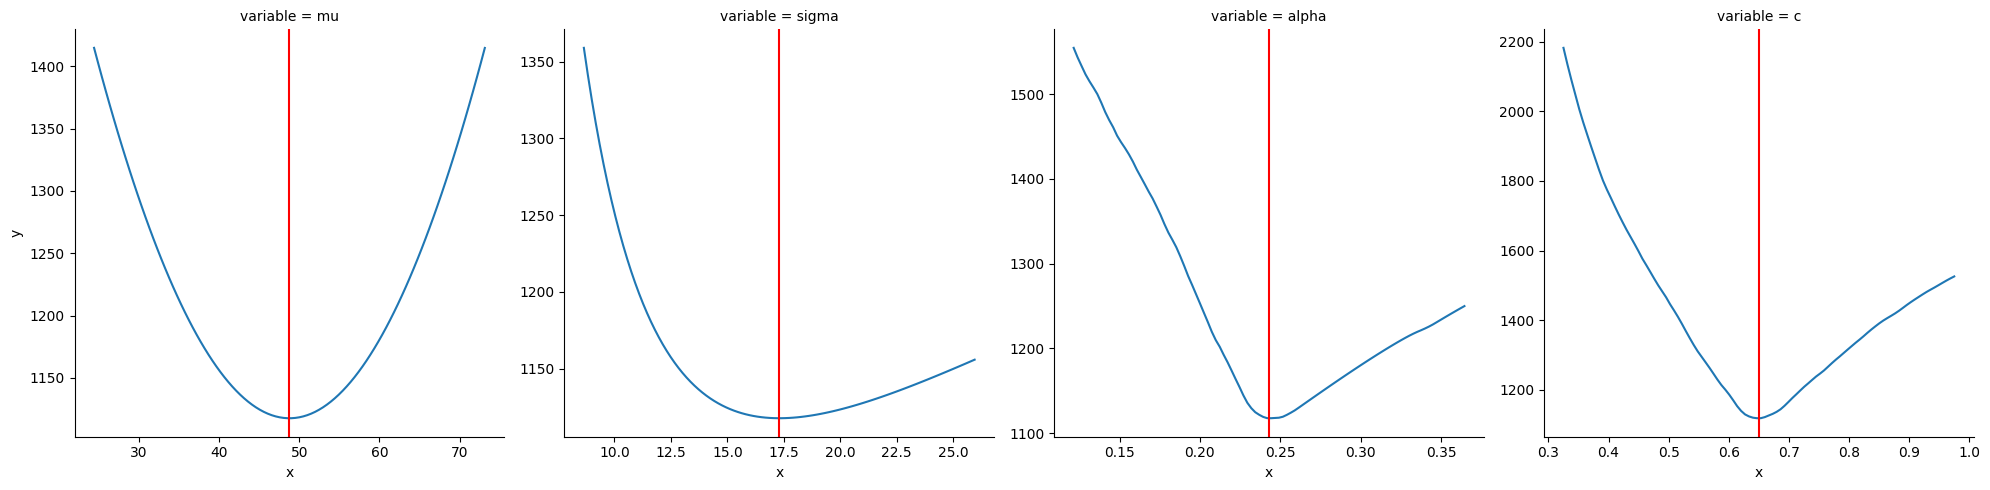

In [89]:
xsol = res.params
xrange = .5
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
theta_rng
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng, 
    n_pts=100, 
    x_names= ['mu','sigma','alpha','c'],
    opt_vlines=True
)

# What if adding `s` as an esimated parameter 

In [90]:

l = l 

@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    c = theta[3]
    s = theta[4]
    lik = dmglik_vmap(y_group = y_obs,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)

    return(-lik)

theta0 = jnp.array([mu,sigma,alpha,c,s])
negdmglik_jax(theta0)

Array(1120.0679, dtype=float32)

In [91]:


solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(theta0)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
theta0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


(Array([48.638584  , 17.38049   ,  0.24481292,  0.65116894,  6.6447434 ],      dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(1116.6555, dtype=float32), success=True, status=0, iter_num=129, hess_inv=None))

Array([48.  , 19.  ,  0.25,  0.65, 10.  ], dtype=float32)

Array([[24.319292  , 72.95788   ],
       [ 8.690245  , 26.070734  ],
       [ 0.12240646,  0.3672194 ],
       [ 0.32558447,  0.9767534 ],
       [ 3.3223717 ,  9.967115  ]], dtype=float32)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


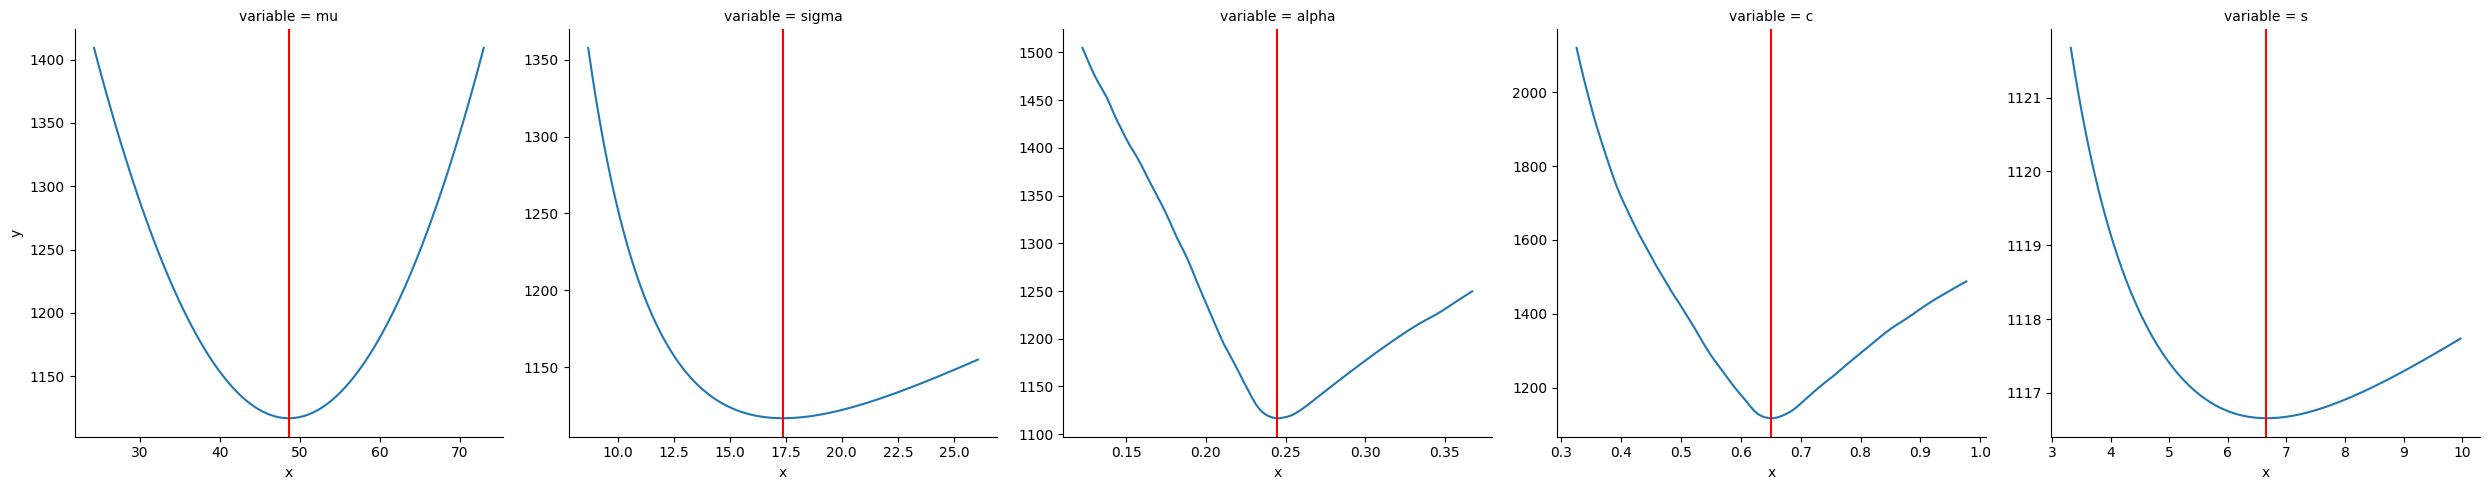

In [92]:
xsol = res.params
xrange = .5
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
theta_rng
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng, 
    n_pts=100, 
    x_names= ['mu','sigma','alpha','c','s'],
    opt_vlines=True
)

In [93]:
jax.grad(negdmglik_jax)( res.params)

Array([ 6.4586848e-04,  1.3731886e-03, -2.5748291e+00, -3.3249593e-01,
       -6.7254021e-03], dtype=float32)